In [52]:
# Basic Imports and Data Setup

import math
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn.preprocessing
from sklearn.utils import shuffle

mnist = scipy.io.loadmat("./hw6_data_dist/letters_data.mat")

mnist_train_data = mnist["train_x"]
#mnist_train_labels = mnist["train_y"] # 1 - 26
mnist_test_data = mnist["test_x"]
mnist_raw_labels = mnist["train_y"]

#Append bias to training data
#ones = np.array([[1 for _ in range(len(mnist_train_data))]])
#mnist_train_data_augmented = np.concatenate((mnist_train_data, ones.T), axis=1)

mnist_train_data, mnist_raw_labels = shuffle(
    mnist_train_data, mnist_raw_labels, random_state=0)

mnist_train_data = sklearn.preprocessing.scale(mnist_train_data)
mnist_test_data = sklearn.preprocessing.scale(mnist_test_data)

logging = False

def logprint(msg):
    if logging:
        print(msg)
        
#print(mnist_train_data[0])

c:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


[23]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


c:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


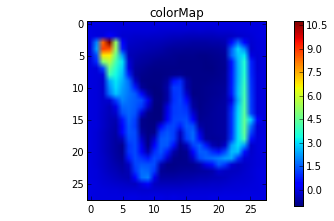

In [53]:
# Data Preprocessing

def labelsToVector(labels):
    result = []
    for label in labels:
        vec = [1 if i+1 == label else 0 for i in range(26)]
        result.append(vec)
    return result

mnist_train_labels = labelsToVector(mnist_raw_labels)

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(mnist_train_data[100].reshape((28,28)))

print(mnist_raw_labels[100])
print(mnist_train_labels[100])


cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

In [64]:
# Main training of the network by SGD

#Note that this works for matrices by element
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#z is predicted, y is actual
def crossEntropy(z, y):
    assert len(z) == len(y)
    entropy = 0
    for j in range(len(z)):
        entropy += y[j] * np.log(z[j]) + (1 - y[j]) * np.log(1 - z[j])
    return -entropy    

def trainNeuralNetwork(images, labels, iterations = 10, learning_rate = 0.01, trainOnNumImages = None, printTrainLoss = False):
    if trainOnNumImages is None:
        trainOnNumImages = len(images)
    
    #V = np.random.rand(200, 785)
    #W = np.random.rand(26, 201)
    
    #V = np.random.normal(0, math.sqrt(1/785), (200,785))
    #W = np.random.normal(0, math.sqrt(1/201), (26,201))
    
    V = np.random.normal(0, 0.1, (200,785))
    W = np.random.normal(0, 0.1, (26,201))
    
    for r in range(200):
        V[r][784] = 1
    for r in range(26):
        W[r][200] = 1
        
    while iterations > 0:
        #Choose a random index for SGD, we'll use this to update
        logprint("Start, first multiplications")
        
        index = int(np.random.random() * trainOnNumImages)
        X_i = images[index] #The data
        y_i = labels[index] #The correct value as a vector
        X_augmented = np.concatenate((X_i, np.array([1])))
        
        #Compute the forward pass by simple matrix multiplication
        #hidden = V * X_i
        #200 x 1 = 200 x 785 * 785 x 1
        hidden = np.dot(V, X_augmented)
        hidden_activated = np.tanh(hidden)
        #V 201 x 1
        hidden_activated_bias = np.concatenate((hidden_activated, np.array([1])))
        
        logprint("Second multiplication")
        
        #output = W * hidden_bias
        #26 x 1 = 26 x 201 * 201 x 1
        output = np.dot(W, hidden_activated_bias)
        output_activated = sigmoid(output)
        
        entropy = crossEntropy(output_activated, y_i)
        
        if printTrainLoss:
            print(output_activated)
            print("Predicted in SGD for index " + str(index) + ", predicted " + str(findPrediction(output_activated)))
            print("True value: " + str(findPrediction(y_i)))
            count = 0
            predictions = predictNeuralNetwork(mnist_train_data[0:trainOnNumImages], V, W)
            for i in range(len(predictions)):
                if str(findPrediction(predictions[i])) == str(mnist_raw_labels[i][0]):
                    count += 1
            print("Training Accuracy: " + str(float(count)/float(len(predictions))))
            print("Entropy: " + str(entropy))
            print("------------------")
        
        #SGD
        
        V_copy = np.array(V)
        W_copy = np.array(W)
        
        derivatives_store = []
        
        logprint("Precompute derivatives")
        
        for outputIndex in range(len(output)):
            left = - y_i[outputIndex] / output_activated[outputIndex]
            left += (1 - y_i[outputIndex]) / (1 - output_activated[outputIndex])
            middle = output_activated[outputIndex] * (1 - output_activated[outputIndex])
            derivatives_store.append(left * middle)
        
        logprint("Hidden-output weight calculations")
        
        for outputIndex in range(len(output)): #for every unit in the output layer
            leftmiddle = derivatives_store[outputIndex]
            for hiddenIndex in range(len(hidden)):
                #left = - y_i[outputIndex] / output_activated[outputIndex] + (1 - y_i[outputIndex]) / (1 - output_activated[outputIndex])
                #middle = output_activated[outputIndex] * (1 - output_activated[outputIndex])
                right = hidden_activated[hiddenIndex]
                d_e_weight = leftmiddle * right
                W_copy[outputIndex][hiddenIndex] -= learning_rate * d_e_weight
        
        logprint("Input-hidden weight calculations")
        
        for hiddenIndex in range(len(hidden)):
            sum_outgoing = 0
            middle = 1 - hidden_activated[hiddenIndex]*hidden_activated[hiddenIndex]
            
            for outputIndex in range(26):
                sum_outgoing += derivatives_store[outputIndex] * W[outputIndex][hiddenIndex]
            for inputIndex in range(len(X_i) - 1):
                right = X_i[inputIndex]
                d_e_weight = sum_outgoing * middle * right
                V_copy[hiddenIndex][inputIndex] -= learning_rate * d_e_weight
        
        if iterations % 100 == 0:
            print("Iterations left: " + str(iterations))
        
        #Do some gradient checking
        
        
        iterations -= 1
        
        V = V_copy
        W = W_copy

    return V, W



In [24]:
print(np.tanh(np.array([[1,2,3,4],[5,6,7,8]])))

[[ 0.76159416  0.96402758  0.99505475  0.9993293 ]
 [ 0.9999092   0.99998771  0.99999834  0.99999977]]


In [41]:
trainedV, trainedW = trainNeuralNetwork(mnist_train_data, mnist_train_labels, 5000, 0.05)

Finished iteration: 5000
Finished iteration: 4900
Finished iteration: 4800
Finished iteration: 4700
Finished iteration: 4600
Finished iteration: 4500
Finished iteration: 4400
Finished iteration: 4300
Finished iteration: 4200
Finished iteration: 4100
Finished iteration: 4000
Finished iteration: 3900
Finished iteration: 3800
Finished iteration: 3700
Finished iteration: 3600
Finished iteration: 3500
Finished iteration: 3400
Finished iteration: 3300
Finished iteration: 3200
Finished iteration: 3100
Finished iteration: 3000
Finished iteration: 2900
Finished iteration: 2800
Finished iteration: 2700
Finished iteration: 2600
Finished iteration: 2500
Finished iteration: 2400
Finished iteration: 2300
Finished iteration: 2200
Finished iteration: 2100


KeyboardInterrupt: 

In [65]:
checkLen = 30

checkV, checkW = trainNeuralNetwork(mnist_train_data, mnist_train_labels, 100, 0.03, checkLen, False)

predictions = predictNeuralNetwork(mnist_train_data[0:checkLen], checkV, checkW)

count = 0
for i in range(len(predictions)):
    logprint(str(findPrediction(predictions[i]) + 1) + ": " + str(mnist_raw_labels[i]))
    if str(findPrediction(predictions[i]) + 1) == str(mnist_raw_labels[i][0]):
        count += 1
    #print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))
    
validationPred = predictNeuralNetwork(mnist_train_data[checkLen:checkLen + 100], checkV, checkW)
    
print("Training Accuracy: " + str(count/len(predictions)))

Iterations left: 100
Training Accuracy: 0.8333333333333334


In [6]:
def findPrediction(prediction):
    maxIndex = -1
    maxIndexScore = 0
    for i in range(len(prediction)):
        if prediction[i] > maxIndexScore or maxIndex == -1:
            maxIndex = i
            maxIndexScore = prediction[i]
    return maxIndex

def predictNeuralNetwork(images, V, W):
    predictions = []
    for index in range(len(images)):
        prediction = calculateVal(images[index], V, W)
        predictions.append(prediction)
    return predictions
    
def calculateVal(X_i, V, W):    
    #Compute the forward pass by simple matrix multiplication
    #hidden = V * X_i
    #200 x 1 = 200 x 785 * 785 x 1
    X_augmented = np.concatenate((X_i, np.array([1])))
    
    hidden = np.dot(V, X_augmented)
    hidden_activated = np.tanh(hidden)
    #V 201 x 1
    hidden_activated_bias = np.concatenate((hidden_activated, np.array([1])))

    #output = W * hidden_bias
    #26 x 1 = 26 x 201 * 201 x 1
    output = np.dot(W, hidden_activated_bias)
    output_activated = sigmoid(output)

    return output_activated
    

In [ ]:
predictions = predictNeuralNetwork(mnist_train_data, trainedV, trainedW)

for i in range(200):
    print(str(predictions[i]) + " " + str(findPrediction(predictions[i])) + ": " + str(mnist_raw_labels[i]))